# [SDXL] Null-text inversion + Editing with Prompt-to-Prompt
https://github.com/ugiugi0823

In [8]:
import subprocess, diffusers, os, sys

def get_total_gpu_memory():
    result = subprocess.run('nvidia-smi | grep "MiB /"', shell=True, stdout=subprocess.PIPE)
    output = result.stdout.decode('utf-8').strip()
    
    
    total_memory = output.split('|')[2].strip().split()[2]

    total_memory_number = ''.join(filter(str.isdigit, total_memory))
    return total_memory_number

total_gpu_memory = get_total_gpu_memory()
if int(total_gpu_memory) < 49140:
    print(f"Your gpu memory{total_gpu_memory}")
    print("Get at least 49140 MiB GPUs.")


os.environ['CUDA_VISIBLE_DEVICES'] = '0'
if diffusers.__version__ == "0.21.4":
    print("The diffusers version is 0.21.4.")
else:
    print(f"The diffusers version is not 0.21.4. Current version: {diffusers.__version__}")

pid = os.getpid()
print("PID of the current process: ", pid)



if sys.version.startswith("3.8"):
    print("Python version is 3.8.")
else:
    print(f"Python version is not 3.8. Current version: {sys.version}")



The diffusers version is 0.21.4.
PID of the current process:  2673784
Python version is 3.8.


In [ ]:
import torch
from diffusers import  DiffusionPipeline, DDIMScheduler

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
model = "stabilityai/stable-diffusion-xl-base-1.0"
SDXL = DiffusionPipeline.from_pretrained(
        model,
        scheduler=scheduler,
        torch_dtype=torch.float32,
    ).to(device)


pjf_path = "./lora"
SDXL.load_lora_weights(pjf_path, weight_name="pytorch_lora_weights.safetensors")
SDXL.disable_xformers_memory_efficient_attention()
SDXL.enable_model_cpu_offload()


## Local

In [6]:
import gc, abc, torch, shutil
import ptp_utils
import seq_aligner

import torch.nn.functional as nnf
import torch.nn.functional as F
import numpy as np


from diffusers import DiffusionPipeline, AutoencoderKL, DDIMScheduler
from typing import Optional, Union, Tuple, List, Callable, Dict
from tqdm import tqdm
from transformers import AutoTokenizer

from PIL import Image, ImageEnhance
from compel import Compel, ReturnedEmbeddingsType

tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

LOW_RESOURCE = False
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 5.0
MAX_NUM_WORDS = 77


class LocalBlend:

    def get_mask(self, x_t, maps, alpha, use_pool):
        
        k = 1
        
        
        maps = (maps * self.alpha_layers).sum(-1).mean(1) # since alpha_layers is all 0s except where we edit, the product zeroes out all but what we change. Then, the sum adds the values of the original and what we edit. Then, we average across dim=1, which is the number of layers.
        mask = F.max_pool2d(maps, (k * 2 + 1, k * 2 + 1), (1, 1), padding=(k, k))
        mask = F.interpolate(mask, size=(x_t.shape[2:]))
        mask = mask / mask.max(2, keepdims=True)[0].max(3, keepdims=True)[0]
        mask = mask.gt(self.th)
        mask = mask[:1] + mask
        return mask

    def __call__(self, x_t, attention_store):
        self.counter += 1
        wxxk_test = attention_store
        
        
        if self.counter > self.start_blend:
            
            maps = [m for m in attention_store["down_cross"] + attention_store["mid_cross"] +  attention_store["up_cross"] if m.shape[1] == self.attn_res[0] * self.attn_res[1]]
            maps = [item.reshape(self.alpha_layers.shape[0], -1, 1, self.attn_res[0], self.attn_res[1], MAX_NUM_WORDS) for item in maps]
            maps = torch.cat(maps, dim=1)
            
 
            mask = self.get_mask(x_t,maps, self.alpha_layers, True)
            
            
            if self.substruct_layers is not None:
                maps_sub = ~self.get_mask(maps, self.substruct_layers, False)
                mask = mask * maps_sub
                
                
            mask = mask.float()
            # mask = mask.to(torch.float16)
            x_t = x_t[:1] + mask * (x_t - x_t[:1])
        return x_t

    def __init__(self, model,prompts: List[str], words: [List[List[str]]], substruct_words=None, start_blend=0.2, th=(.3, .3)):
        tokenizer = model.tokenizer
        alpha_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
        for i, (prompt, words_) in enumerate(zip(prompts, words)):
            if type(words_) is str:
                words_ = [words_]
            for word in words_:
                ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                alpha_layers[i, :, :, :, :, ind] = 1

        if substruct_words is not None:
            substruct_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
            for i, (prompt, words_) in enumerate(zip(prompts, substruct_words)):
                if type(words_) is str:
                    words_ = [words_]
                for word in words_:
                    ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                    substruct_layers[i, :, :, :, :, ind] = 1
            self.substruct_layers = substruct_layers.to(device)
        else:
            self.substruct_layers = None
        self.alpha_layers = alpha_layers.to(device)
        self.start_blend = int(start_blend * NUM_DDIM_STEPS)
        self.counter = 0
        th = 0.3
        self.th=th
        attn_res = int(np.ceil(1024 / 32)), int(np.ceil(1024 / 32))
        self.attn_res = attn_res




class EmptyControl:


    def step_callback(self, x_t):
        
        return x_t

    def between_steps(self):
        return

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        return attn


class AttentionControl(abc.ABC):

    def step_callback(self, x_t):
        
        
        return x_t

    def between_steps(self):
        return

    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0

    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                # attn = attn.reshape(20, 1024, 64)
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn

    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class SpatialReplace(EmptyControl):

    def step_callback(self, x_t):
        
        if self.cur_step < self.stop_inject:
            b = x_t.shape[0]
            x_t = x_t[:1].expand(b, *x_t.shape[1:])
        return x_t

    def __init__(self, stop_inject: float):
        super(SpatialReplace, self).__init__()
        self.stop_inject = int((1 - stop_inject) * NUM_DDIM_STEPS)


class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        
        
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        key_info = self.attention_store.keys()
        # print(key_info)
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}


class AttentionControlEdit(AttentionStore, abc.ABC):

    def step_callback(self, x_t):
        
        if self.local_blend is not None:
            x_t = self.local_blend(x_t, self.attention_store)
        return x_t

    def replace_self_attention(self, attn_base, att_replace, place_in_unet):
        
        if att_replace.shape[2] <= 32 ** 2:
            
            attn_base = attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
            return attn_base
        else:
            return att_replace

    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace):
        raise NotImplementedError

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
        
        
        if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
            
            
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
            attn_base, attn_repalce = attn[0], attn[1:]
            if is_cross:
                
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_repalce_new = self.replace_cross_attention(attn_base, attn_repalce) * alpha_words + (1 - alpha_words) * attn_repalce
                attn[1:] = attn_repalce_new
            else:
                attn[1:] = self.replace_self_attention(attn_base, attn_repalce, place_in_unet)
            attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
        return attn

    def __init__(self, prompts, num_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
                 self_replace_steps: Union[float, Tuple[float, float]],
                 local_blend: Optional[LocalBlend]):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        self.cross_replace_alpha = ptp_utils.get_time_words_attention_alpha(prompts, num_steps, cross_replace_steps, tokenizer).to(device)
        if type(self_replace_steps) is float:
            self_replace_steps = 0, self_replace_steps
        self.num_self_replace = int(num_steps * self_replace_steps[0]), int(num_steps * self_replace_steps[1])
        self.local_blend = local_blend

class AttentionReplace(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper)

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        
        self.mapper = seq_aligner.get_replacement_mapper(prompts, tokenizer).to(device)


class AttentionRefine(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        attn_base_replace = attn_base[:, :, self.mapper].permute(2, 0, 1, 3)
        attn_replace = attn_base_replace * self.alphas + att_replace * (1 - self.alphas)
        # attn_replace = attn_replace / attn_replace.sum(-1, keepdims=True)
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionRefine, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper, alphas = seq_aligner.get_refinement_mapper(prompts, tokenizer)
        self.mapper, alphas = self.mapper.to(device), alphas.to(device)
        self.alphas = alphas.reshape(alphas.shape[0], 1, 1, alphas.shape[1])


class AttentionReweight(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        if self.prev_controller is not None:
            attn_base = self.prev_controller.replace_cross_attention(attn_base, att_replace)
        attn_replace = attn_base[None, :, :, :] * self.equalizer[:, None, None, :]
        # attn_replace = attn_replace / attn_replace.sum(-1, keepdims=True)
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float, equalizer,
                local_blend: Optional[LocalBlend] = None, controller: Optional[AttentionControlEdit] = None):
        super(AttentionReweight, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.equalizer = equalizer.to(device)
        self.prev_controller = controller


def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
                  Tuple[float, ...]]):
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = torch.ones(1, 77)

    for word, val in zip(word_select, values):
        inds = ptp_utils.get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = val
    return equalizer

def aggregate_attention(prompts,attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    
    num_pixels = res ** 2
    for location in from_where:
        if attention_maps[f"{location}_{'cross' if is_cross else 'self'}"] is not None:
            for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
                if item.shape[1] == num_pixels:
                    
                    cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                    
                    out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def make_controller(model,prompts: List[str], is_replace_controller: bool, cross_replace_steps: Dict[str, float], self_replace_steps: float, blend_words=None, equilizer_params=None, blend_word=None) -> AttentionControlEdit:
    if blend_words is None:
        
        lb = None
    else:
        
        lb = LocalBlend(model,prompts, blend_word)
    if is_replace_controller:
        
        controller = AttentionReplace(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
    else:
        controller = AttentionRefine(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps, self_replace_steps=self_replace_steps, local_blend=lb)
    if equilizer_params is not None:
        
        eq = get_equalizer(prompts[1], equilizer_params["words"], equilizer_params["values"])
        controller = AttentionReweight(prompts, NUM_DDIM_STEPS, cross_replace_steps=cross_replace_steps,
                                       self_replace_steps=self_replace_steps, equalizer=eq, local_blend=lb, controller=controller)
    return controller


def show_cross_attention(model, prompts, attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    
    tokenizer = model.tokenizer 
    tokens = tokenizer.encode(prompts[select])
    
    
    decoder = tokenizer.decode
    
    attention_maps = aggregate_attention(prompts,attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        
        # # Pillow 이미지로 변환
        image = Image.fromarray(image)
        # # 명암 대비를 증가시키기
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(4.0)  # 대비 인자 조정
        
        # 256x256 크기로 조정
        resized_image = image.resize((256, 256))
        image_with_text = ptp_utils.text_under_image(np.array(resized_image), decoder(int(tokens[i])))
        images.append(image_with_text)
        
        
        
    ptp_utils.view_images(np.stack(images, axis=0))
    


def show_self_attention_comp(attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    ptp_utils.view_images(np.concatenate(images, axis=1))
    
    

@torch.no_grad()
def text2image_ldm_stable(
    model,
    neg_prompt:  List[str],
    prompt:  List[str],
    controller,
    num_inference_steps: int = 50,
    guidance_scale: Optional[float] = 7.5,
    generator: Optional[torch.Generator] = None,
    latent: Optional[torch.FloatTensor] = None,
    uncond_embeddings=None,
    uncond_embeddings_p=None,
    start_time=50,
    return_type='image'
):
    batch_size = len(prompt)
    ptp_utils.register_attention_control(model, controller)
    
    compel = Compel(
    tokenizer=[model.tokenizer, model.tokenizer_2] ,
    text_encoder=[model.text_encoder, model.text_encoder_2],
    returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
    requires_pooled=[False, True]
    )
    

    
    
    
    prompt_embeds, pooled_prompt_embeds = compel(prompt)
    negative_prompt_embeds, negative_pooled_prompt_embeds = compel(neg_prompt) 
    
    
    

    model.vae_scale_factor = 2 ** (len(model.vae.config.block_out_channels) - 1)
    model.default_sample_size = model.unet.config.sample_size
    
    height = model.default_sample_size * model.vae_scale_factor
    width =  model.default_sample_size * model.vae_scale_factor
    
    # height = width = 512

    original_size =  (height, width)
    target_size = (height, width)
    crops_coords_top_left = (0, 0)    
    add_time_ids = list(original_size + crops_coords_top_left + target_size)
    
    passed_add_embed_dim = (
        model.unet.config.addition_time_embed_dim * len(add_time_ids) + model.text_encoder_2.config.projection_dim
    )
    expected_add_embed_dim = model.unet.add_embedding.linear_1.in_features

    

    if expected_add_embed_dim != passed_add_embed_dim:
        raise ValueError(
            f"Model expects an added time embedding vector of length {expected_add_embed_dim}, but a vector of {passed_add_embed_dim} was created. The model has an incorrect config. Please check `unet.config.time_embedding_type` and `text_encoder_2.config.projection_dim`."
        )

    add_time_ids = torch.tensor([add_time_ids], dtype=model.unet.dtype).to(model.device)
    batch_size = prompt_embeds.shape[0]
    num_images_per_prompt = 1
    add_time_ids = add_time_ids.repeat(batch_size * num_images_per_prompt, 1)

    
    add_time_ids = torch.cat([add_time_ids, add_time_ids], dim=0) 
    
    if uncond_embeddings is None:
        uncond_embeddings_ = negative_prompt_embeds
    else:
        uncond_embeddings_ = None

    latent, latents = ptp_utils.init_latent(latent, model, height, width, generator, batch_size)
    model.scheduler.set_timesteps(num_inference_steps)
    
    torch.cuda.empty_cache()
    for i, t in enumerate(tqdm(model.scheduler.timesteps[-start_time:])):
        if uncond_embeddings_ is None:
            context = torch.cat([uncond_embeddings[i].expand(*prompt_embeds.shape).to(model.device), prompt_embeds.to(model.device)]) 
            context_p = torch.cat([uncond_embeddings_p[i].expand(*pooled_prompt_embeds.shape).to(model.device), pooled_prompt_embeds.to(model.device)]) 

        else:
            context = torch.cat([uncond_embeddings_, prompt_embeds]) 
        
        
        latents = ptp_utils.diffusion_step(model, controller, latents, context, context_p, add_time_ids, t, guidance_scale, low_resource=False)

    if return_type == 'image':
        
        image = ptp_utils.latent2image(model.vae, latents)
        
    else:
        image = latents
    return image, latent



def run_and_display(model,neg_prompts,prompts, controller, latent=None, run_baseline=False, generator=None, uncond_embeddings=None,uncond_embeddings_p=None,add_time_ids1=None ,verbose=True, steps=50):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = text2image_ldm_stable(model, neg_prompts,prompts, controller, latent=latent, num_inference_steps=steps, guidance_scale=GUIDANCE_SCALE, generator=generator, uncond_embeddings=uncond_embeddings, uncond_embeddings_p=uncond_embeddings_p)
    if verbose:
        ptp_utils.view_images(images)
    return images, x_t


WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.2.2+cu121 with CUDA 1201 (you have 2.2.0)
    Python  3.8.19 (you have 3.8.18)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


## Null

In [7]:
import numpy as np
import ptp_utils
import seq_aligner
import abc, shutil
import torch
import torch.nn.functional as nnf

from diffusers import DiffusionPipeline, StableDiffusionXLImg2ImgPipeline, AutoencoderKL, StableDiffusionPipeline, DDIMScheduler
from typing import Optional, Union, Tuple, List, Callable, Dict
from diffusers.utils import load_image
from diffusers.utils.torch_utils import randn_tensor
from tqdm import tqdm
from torch.optim.adam import Adam
from PIL import Image
from compel import Compel, ReturnedEmbeddingsType




LOW_RESOURCE = False
NUM_DDIM_STEPS = 50
GUIDANCE_SCALE = 5.0
MAX_NUM_WORDS = 77

def load_img(image_path, do_1024=False):
    
    image = Image.open(image_path)

    if do_1024:
        if image.size[0] != 1024:
            image = image.resize((1024, 1024)) 
        
            
    else:
        if image.size[0] != 512:
            image = image.resize((512, 512)) 
            
        
    image = np.array(image)
    print("🌊 image resize = ",image.shape)
    if np.isnan(image).any():
        raise ValueError("NaN detected in load_img!")

    return image


class NullInversion:

    def prev_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        prev_sample = self.scheduler.step(model_output, timestep, sample, return_dict=False)[0]
        
        return prev_sample
    
    

    def next_step(self, model_output: Union[torch.FloatTensor, np.ndarray], timestep: int, sample: Union[torch.FloatTensor, np.ndarray]):
        time_term = self.scheduler.config.num_train_timesteps // self.scheduler.num_inference_steps 
        timestep, next_timestep = min(timestep, 999), min(timestep + time_term, 999)

        
        
        alpha_prod_t = self.scheduler.alphas_cumprod[timestep] if timestep >= 0 else self.scheduler.final_alpha_cumprod
        alpha_prod_t_next = self.scheduler.alphas_cumprod[next_timestep]
        beta_prod_t = 1 - alpha_prod_t        
        beta_prod_t_next = 1 - alpha_prod_t_next

        variance = (beta_prod_t_next / beta_prod_t) * (1 - alpha_prod_t / alpha_prod_t_next)

        eta = 0.1
        std_dev_t = eta * variance ** (0.5)
        
        next_original_sample = (sample - beta_prod_t ** 0.5 * model_output) / alpha_prod_t ** 0.5        
        next_sample_direction = (1 - alpha_prod_t_next) ** (0.5) * model_output
        next_sample = alpha_prod_t_next ** (0.5) * next_original_sample + next_sample_direction
        
        
        
        
        return next_sample

    def get_noise_pred_single(self, latents, t, context, context_p, add_time_ids):        
        latents = self.scheduler.scale_model_input(latents, t)
        added_cond_kwargs = {"text_embeds": context_p, "time_ids": add_time_ids}
        noise_pred = self.model.unet(latents, 
                                     t, 
                                     encoder_hidden_states=context,
                                     added_cond_kwargs=added_cond_kwargs,
                                     )["sample"]
        return noise_pred
    

    
    


    def get_noise_pred(self, latents, t, is_forward=True, context=None, context_p=None, add_time_ids=None):
        latents_input = torch.cat([latents] * 2)
        
        context = context if context is not None else self.context
        context_p = context_p if context_p is not None else self.context_p
        add_time_ids = add_time_ids if add_time_ids is not None else self.add_time_ids
        
        
        
        guidance_scale = 1 if is_forward else GUIDANCE_SCALE
    
        
        latents_input = self.scheduler.scale_model_input(latents_input, t)
        added_cond_kwargs = {"text_embeds": context_p, "time_ids": add_time_ids}
        noise_pred = self.model.unet(latents_input, 
                                     t, 
                                     encoder_hidden_states=context,
                                     added_cond_kwargs=added_cond_kwargs,
                                     )["sample"]
       
        
        
        
        noise_pred_uncond, noise_prediction_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)
        if is_forward:
            latents = self.next_step(noise_pred, t, latents)
        else:
            latents = self.prev_step(noise_pred, t, latents)
        return latents
    
    

    @torch.no_grad()
    def latent2image(self, latents, return_type='np'):
        latents = 1 / 0.13025 * latents.detach()
        # latents = latents.to(torch.float32)
        
        image = self.model.vae.decode(latents)['sample']
        if return_type == 'np':
            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()[0]        
            image = (image * 255).round().astype(np.uint8)
            
            
            
        
        return image




    @torch.no_grad()
    def image2latent(self, image):

        with torch.no_grad():
            if type(image) is Image:
                image = np.array(image)
            if type(image) is torch.Tensor and image.dim() == 4:
                latents = image
            else:
                
                image = torch.from_numpy(image).float() / 127.5 - 1   
                image = image.permute(2, 0, 1).unsqueeze(0).to("cuda")
                
                generator = torch.Generator("cuda").manual_seed(33)

                latents = self.model.vae.encode(image.to(self.model.unet.dtype)).latent_dist.sample(generator)
                # latents = self.model.vae.encode(image.to(self.model.unet.dtype))['latent_dist'].mean
                
                
                if torch.isnan(latents).any():
                    print("wldnjsdfjklsfjkld")
                    # raise ValueError("NaN detected in image2latent!")
                    
                
                latents = latents * 0.13025

                print("🌊 latents.size = ",latents.size())    
        return latents




    @torch.no_grad()
    def init_prompt(self, prompt: str):
        
        compel = Compel(
        tokenizer=[self.model.tokenizer, self.model.tokenizer_2] ,
        text_encoder=[self.model.text_encoder, self.model.text_encoder_2],
        returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
        requires_pooled=[False, True]
        )
        
        prompt_embeds, pooled_prompt_embeds = compel(prompt)
        negative_prompt_embeds, negative_pooled_prompt_embeds = compel("") 
   
        self.model.vae_scale_factor = 2 ** (len(self.model.vae.config.block_out_channels) - 1)
        self.model.default_sample_size = self.model.unet.config.sample_size
        
        height = self.model.default_sample_size * self.model.vae_scale_factor
        width =  self.model.default_sample_size * self.model.vae_scale_factor
        
        
        
        

        original_size =  (height, width)
        target_size = (height, width)
        crops_coords_top_left = (0, 0)    
        add_time_ids = list(original_size + crops_coords_top_left + target_size)
        
        passed_add_embed_dim = (
            self.model.unet.config.addition_time_embed_dim * len(add_time_ids) + self.model.text_encoder_2.config.projection_dim
        )
        expected_add_embed_dim = self.model.unet.add_embedding.linear_1.in_features

        

        if expected_add_embed_dim != passed_add_embed_dim:
            raise ValueError(
                f"Model expects an added time embedding vector of length {expected_add_embed_dim}, but a vector of {passed_add_embed_dim} was created. The model has an incorrect config. Please check `unet.config.time_embedding_type` and `text_encoder_2.config.projection_dim`."
            )

        add_time_ids = torch.tensor([add_time_ids], dtype=self.model.unet.dtype).to(self.model.device)
        batch_size = prompt_embeds.shape[0]
        num_images_per_prompt = 1
        add_time_ids = add_time_ids.repeat(batch_size * num_images_per_prompt, 1)

        

        
        self.context = torch.cat([negative_prompt_embeds, prompt_embeds])
        self.context_p = torch.cat([negative_pooled_prompt_embeds, pooled_prompt_embeds])
        self.add_time_ids = torch.cat([add_time_ids, add_time_ids])        
        self.prompt = prompt


    @torch.no_grad()
    def ddim_loop(self, latent):

        uncond_embeddings_p, cond_embeddings_p = self.context_p.chunk(2)
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        add_time_ids1, add_time_ids2 = self.add_time_ids.chunk(2)
        all_latent = [latent]
        latent = latent.clone().detach()
        
        
        
        
        for i in range(NUM_DDIM_STEPS):
            t = self.model.scheduler.timesteps[len(self.model.scheduler.timesteps) - i - 1]
            noise_pred = self.get_noise_pred_single(latent, t, cond_embeddings, cond_embeddings_p, add_time_ids2)
            latent = self.next_step(noise_pred, t, latent)
            all_latent.append(latent)
            
            
        return all_latent


    @property
    def scheduler(self):
        return self.model.scheduler

    @torch.no_grad()
    def ddim_inversion(self, image):
        latent = self.image2latent(image)
               
        image_rec = self.latent2image(latent)

        ddim_latents = self.ddim_loop(latent)

        return image_rec, ddim_latents
    
    

    def null_optimization(self, latents, num_inner_steps, epsilon):
    
        uncond_embeddings_p, cond_embeddings_p = self.context_p.chunk(2)
        uncond_embeddings, cond_embeddings = self.context.chunk(2)
        add_time_ids1, add_time_ids2 = self.add_time_ids.chunk(2)
        
            
        uncond_embeddings_list = []
        uncond_embeddings_p_list = []
        add_time_ids1_list = []
        latent_cur = latents[-1]
        # print(latent_cur.size())

        # Set total for tqdm
        # total_iterations = num_inner_steps * NUM_DDIM_STEPS 
        total_iterations = NUM_DDIM_STEPS 
        bar = tqdm(total=total_iterations)
        
        
        for i in range(NUM_DDIM_STEPS):
            
            
            uncond_embeddings = uncond_embeddings.clone().detach().requires_grad_(True)
            uncond_embeddings_p = uncond_embeddings_p.clone().detach().requires_grad_(True)
            add_time_ids1 = add_time_ids1.clone().detach().requires_grad_(True)
            
            optimizer = Adam([uncond_embeddings, uncond_embeddings_p], lr=1e-2 * (1. - i / 100.))
            latent_prev = latents[len(latents) - i - 2]
            t = self.model.scheduler.timesteps[i]
            
            with torch.no_grad():
                noise_pred_cond = self.get_noise_pred_single(latent_cur, t, cond_embeddings, cond_embeddings_p, add_time_ids2)

            for j in range(num_inner_steps):
                noise_pred_uncond = self.get_noise_pred_single(latent_cur, t, uncond_embeddings, uncond_embeddings_p, add_time_ids1)
                noise_pred = noise_pred_uncond + GUIDANCE_SCALE * (noise_pred_cond - noise_pred_uncond)
                latents_prev_rec = self.prev_step(noise_pred, t, latent_cur)
                loss = nnf.mse_loss(latents_prev_rec, latent_prev)
                loss_item = loss.item()
                optimizer.zero_grad()
                loss.backward()
                if torch.isnan(uncond_embeddings.grad).any():
                    
                    print("Nan!!")
                    # bar.update()
                    break
                optimizer.step()
                loss_item = loss.item()
                bar.set_description(f"Step {i}, Iteration {j}/{num_inner_steps}, Loss: {loss_item:.4f}")
                
                if loss_item < epsilon + i * 2e-5:
                    break
                
        
            uncond_embeddings_list.append(uncond_embeddings[:1].detach())
            uncond_embeddings_p_list.append(uncond_embeddings_p[:1].detach())
            
            with torch.no_grad():
                context = torch.cat([uncond_embeddings, cond_embeddings])
                context_p = torch.cat([uncond_embeddings_p, cond_embeddings_p])
                add_time_ids = torch.cat([add_time_ids1, add_time_ids2]) 
                latent_cur = self.get_noise_pred(latent_cur, t, False, context, context_p=context_p, add_time_ids=add_time_ids)
            bar.update()
            
        
        return uncond_embeddings_list, uncond_embeddings_p_list


    def invert(self, image_path: str, prompt: str, num_inner_steps=10, early_stop_epsilon=1e-5, verbose=False, do_1024=False):
        self.init_prompt(prompt)
        ptp_utils.register_attention_control(self.model, None)
        image_gt = load_img(image_path, do_1024)
        if verbose:
            print("----- DDIM inversion...")
        
        image_rec, ddim_latents = self.ddim_inversion(image_gt)

        if verbose:
            print("----- Null-text optimization...")
        uncond_embeddings, uncond_embeddings_p = self.null_optimization(ddim_latents, num_inner_steps, early_stop_epsilon)
        # uncond_embeddings = None
        # uncond_embeddings_p = None
        
        
        return (image_gt, image_rec), ddim_latents[-1], uncond_embeddings, uncond_embeddings_p


    def __init__(self, model):
        scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False,
                                  set_alpha_to_one=False)
        self.model = model
        self.tokenizer = self.model.tokenizer
        self.model.scheduler.set_timesteps(NUM_DDIM_STEPS)
        self.prompt = None
        self.add_time_ids = None
        self.context = None
        self.context_p = None



In [6]:
bigger = False
prompt = "a woman with blonde hair and a blue scarf"
neg_prompt = ""
image_path = "./img/sdxl_tay.png"

null_inversion = NullInversion(SDXL)
(image_gt, image_enc), x_t, uncond_embeddings, uncond_embeddings_p = null_inversion.invert(image_path, prompt, verbose=True, do_1024=bigger)
torch.cuda.empty_cache()
gc.collect()

prompts = [prompt, prompt]
controller = AttentionStore()
neg_prompts =  [neg_prompt, neg_prompt]

image_inv, x_t = run_and_display(SDXL,neg_prompts,prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings, uncond_embeddings_p=uncond_embeddings_p,verbose=False)
ptp_utils.view_images([image_gt, image_enc, image_inv[0]])
ptp_utils.save_individual_images([image_gt, image_enc, image_inv[0]])
show_cross_attention(SDXL,prompts,controller, 32, ["up","down","mid"])

🌊 Dummy Controller Declaration because there is no Controller
🌊 image resize =  (512, 512, 3)
----- DDIM inversion...
🌊 latents.size =  torch.Size([1, 4, 64, 64])
----- Null-text optimization...


Step 31, Iteration 6/10, Loss: 0.0006:  62%|██████▏   | 31/50 [01:37<01:01,  3.22s/it]

100%|██████████| 50/50 [01:16<00:00,  1.53s/it]


Image saved as ./result/result_2024-06-08T16-34-29.png 


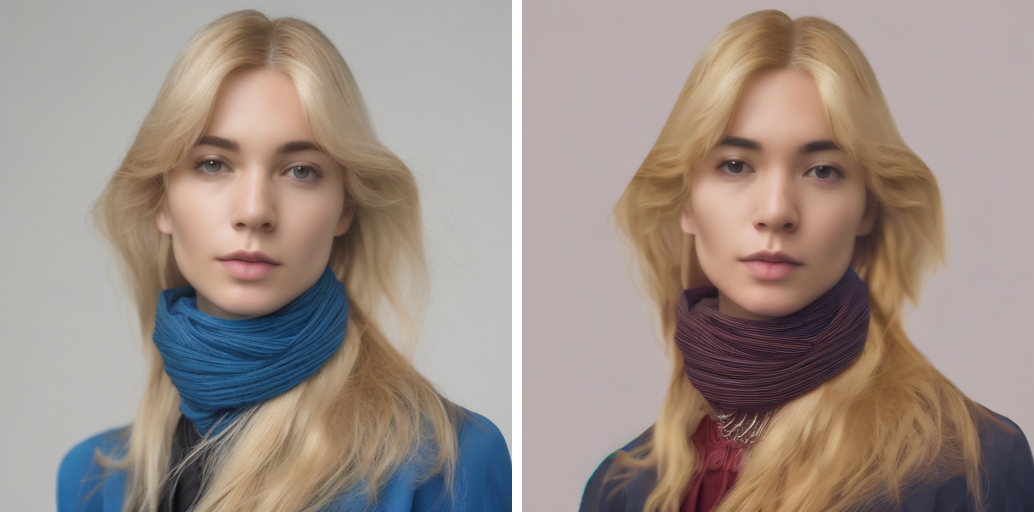

Image is highly affected by the self_replace_steps, usually 0.4 is a good default value, but you may want to try the range 0.3,0.4,0.5,0.7 


In [ ]:
import torch, gc
torch.cuda.empty_cache()
gc.collect()

prompts = ["a woman with blonde hair and a blue scarf",
           "a woman with blonde hair and a red scarf"]

cross_replace_steps = {'default_': 1.0,}
self_replace_steps = 0.4
blend_word = ((('blue',), ("red",))) # for local edit. If it is not local yet - use only the source object: blend_word = ((('cat',), ("cat",))).
eq_params = {"words": ("red",), "values": (2,)} # amplify attention to the word "red" by *2

controller = make_controller(SDXL,prompts, True, cross_replace_steps, self_replace_steps, blend_word, eq_params, blend_word)
images, _ = run_and_display(SDXL,neg_prompts, prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings,uncond_embeddings_p=uncond_embeddings_p, steps=50)


print("Image is highly affected by the self_replace_steps, usually 0.4 is a good default value, but you may want to try the range 0.3,0.4,0.5,0.7 ")

100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


Image saved as ./result/result_2024-06-08T16-36-59.png 


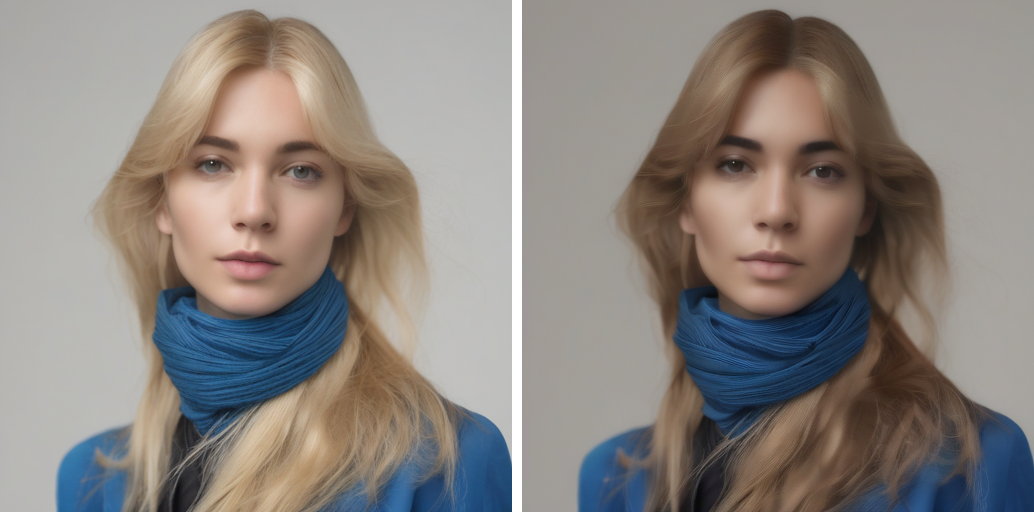

In [ ]:
import torch, gc
torch.cuda.empty_cache()
gc.collect()

prompts = ["a woman with blonde hair and a blue scarf",
           "a woman with brown hair and a blue scarf"]

cross_replace_steps = {'default_': .8,}
self_replace_steps = .8
blend_word = ((('blonde',), ("brown",)))
eq_params = {"words": ("brown",), "values": (2,)} # amplify attention to the word "brown" by *2 

controller = make_controller(SDXL,prompts, True, cross_replace_steps, self_replace_steps, blend_word, eq_params, blend_word)
images, _ = run_and_display(SDXL,neg_prompts, prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings,uncond_embeddings_p=uncond_embeddings_p, steps=50)

100%|██████████| 50/50 [01:24<00:00,  1.69s/it]


Image saved as ./result/result_2024-06-08T17-13-56.png 


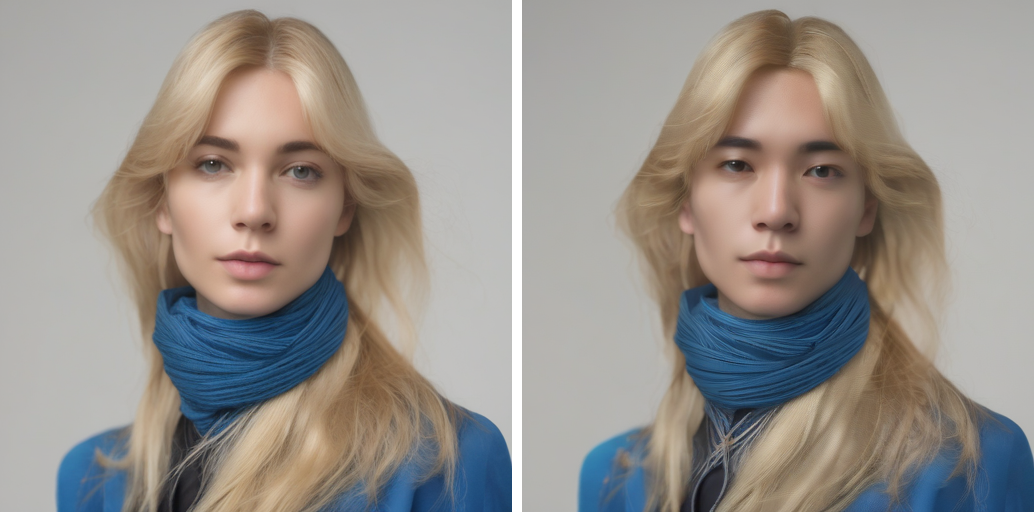

In [ ]:
import torch, gc
torch.cuda.empty_cache()
gc.collect()

prompts = ["a woman with blonde hair and a blue scarf",
           "a man with blonde hair and a blue scarf"]

cross_replace_steps = {'default_': 1.0,}
self_replace_steps = 0.7
blend_word = ((('woman',), ("man",))) 
eq_params = {"words": ("man",), "values": (2,)}

controller = make_controller(SDXL,prompts, True, cross_replace_steps, self_replace_steps, blend_word, eq_params, blend_word)
images, _ = run_and_display(SDXL,neg_prompts, prompts, controller, run_baseline=False, latent=x_t, uncond_embeddings=uncond_embeddings,uncond_embeddings_p=uncond_embeddings_p, steps=50)